<h3> 1. 중요 라이브러리 설치 </h3>

In [ ]:
!pip install Mecab

In [2]:
!pip install konlpy

In [3]:
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.layers import Dense, Activation

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt

import os
from tqdm import tqdm
import pickle

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h3> 2. 노래 데이터 및 모델 데이터 불러오기 </h3>

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random


model = load_model('/content/drive/MyDrive/sentiment_analysis.h5')
music_data = pd.read_csv('/content/drive/MyDrive/music.csv')
music_data.rename(columns = {'lyric' : 'text'}, inplace = True)
music_data.head()

,genre,song_name,artist,text
0,발라드,내 손을 잡아,아이유,느낌이 오잖아\n\n떨리고 있잖아\n\n언제까지 눈치만 볼 거니\n\n네 맘을 말해...
1,발라드,Timeless,SG 워너비,어쩜 살아가다 보면\n한 번은 날 찾을지 몰라\n난 그 기대 하나로\n오늘도 힘겹게...
2,발라드,봄 사랑 벚꽃 말고,"HIGH4 (하이포), 아이유",길었던 겨우내 줄곧 품이 좀 남는\n밤색 코트\n그 속에 나를 쏙 감추고 걸음을\n...
3,발라드,금요일에 만나요 (Feat. 장이정 Of HISTORY),아이유,월요일엔 아마 바쁘지 않을까\n화요일도 성급해 보이지 안 그래\n수요일은 뭔가 어정...
4,발라드,라라라,SG 워너비,그대는 참 아름다워요\n밤 하늘의 별빛보다 빛나요\n지친 나의 마음을 따뜻하게 감싸...


In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 70)          263060    
                                                                 
 lstm_1 (LSTM)               (None, 64)                34560     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 298,010
Trainable params: 298,010
Non-trainable params: 0
_________________________________________________________________


<h3> 3. 텍스트 전처리 </h3>
<li> 불용어 처리 - 한글만 최대한 남기기, \n문자가 많아서 해당 문자 따로 처리

In [50]:
## 불용어, 노이즈 제거 (한글만 최대한 남기는 과정)
x_data = music_data['text'].apply(lambda x : x.replace('\n', ' '))
x_data = x_data.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")
x_data.head()

<ipython-input-50-734215e2fe82>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  x_data = x_data.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")


0    느낌이 오잖아  떨리고 있잖아  언제까지 눈치만 볼 거니  네 맘을 말해봐  딴청 ...
1    어쩜 살아가다 보면 한 번은 날 찾을지 몰라 난 그 기대 하나로 오늘도 힘겹게 버틴...
2    길었던 겨우내 줄곧 품이 좀 남는 밤색 코트 그 속에 나를 쏙 감추고 걸음을 재촉해...
3    월요일엔 아마 바쁘지 않을까 화요일도 성급해 보이지 안 그래 수요일은 뭔가 어정쩡한...
4    그대는 참 아름다워요 밤 하늘의 별빛보다 빛나요 지친 나의 마음을 따뜻하게 감싸줄 ...
Name: text, dtype: object

In [51]:
print(sum(map(len, x_data)) / len(x_data)) ## 노래 가사의 평균 길이

559.9183333333333


Okt를 이용하여 텍스트 전처리 하기

In [52]:
#불용어 처리

okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '것','적', '내', '때'] ## 불용어 제거

song_data = []

########################################################################
# 형태소 분석기 이용하여 토크나이징 진행
# 토크나이징 된 것을 pickle 파일로 저장
########################################################################

if not os.path.isfile('/content/drive/MyDrive/song.pkl'):
  for sentence in tqdm(x_data):
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    song_data.append(stopwords_removed_sentence)
  with open("/content/drive/MyDrive/song.pkl","wb") as f:
    pickle.dump(song_data, f)
else:
    with open("/content/drive/MyDrive/song.pkl","rb") as f:
        song_data = pickle.load(f)

감성 분석 시에 학습하였던 토크나이저 불러오기

In [53]:
with open('/content/drive/MyDrive/tokenizer2.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

song_data = tokenizer.texts_to_sequences(song_data)

########################################################################
# 토크나이징 된 결과를 이용하여 단어를 숫자로 바꾸는 과정
# 희귀 단어 확인하기
########################################################################

threshold = 30
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value
  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

리뷰의 최대 길이 : 485
리뷰의 평균 길이 : 147.42666666666668


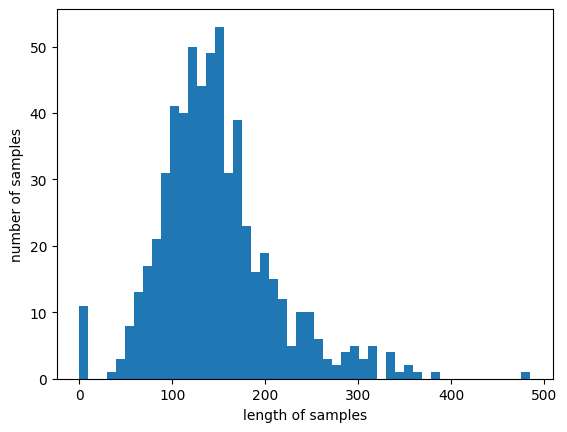

In [55]:
########################################################################
# 전체적으로 문장의 길이가 어떻게 되는 지 파악하기 (노래 가사와 감성 분석 문장 사이의 차이점 확인)
########################################################################

print('리뷰의 최대 길이 :',max(len(review) for review in song_data))
print('리뷰의 평균 길이 :',sum(map(len, song_data))/len(song_data))
plt.hist([len(review) for review in song_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

감성 분석 학습 때와 동일한 방법으로 padding sequence의 length 설정하기

In [57]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 70
below_threshold_len(max_len, song_data)

전체 샘플 중 길이가 70 이하인 샘플의 비율: 6.333333333333334


padding sequence 길이 설정하고, padding된 결과를 노래 가사 데이터에도 동일하게 감성 분석 진행

In [83]:
song_data = pad_sequences(song_data, maxlen = max_len)

from numpy import argmax
output = np.argmax(model.predict(song_data), axis = 1)
music_data['label'] = output
music_data['label'].value_counts()

19/19 [==============================] - 0s 16ms/step


5    271
2    115
4    103
0     60
1     37
3     14
Name: label, dtype: int64

<h3> 4. sample text로 감성분석 결과 확인하고, 노래 추천과정 확인하기 </h3>

In [70]:
sample_text = '그래. 시험은 내년에도 있으니까 지금이라도 다시 열심히 공부하는게 좋겠어. 잘 생각하셨어요. 응원할게요. 학교에 친구가 없어서 외로워. 친구가 없어서 외로우시군요 부디 힘내시길 바래요. 고마워 그래도 학교에 친구가 없다는건 고역이란 말이지. 어떻게 하면 친구를 사귀시길 수 있을지 함께 고민해보죠.'
sample_token = tokenizer.texts_to_sequences([sample_text])
sample_token = pad_sequences(sample_token, maxlen = 70)
predict_label = np.argmax(model.predict(sample_token), axis = 1)
predict_label

1/1 [==============================] - 0s 72ms/step


array([1])

sample text와 유사한 감정을 가진 노래 가사 출력하기

In [78]:
music_lyrics = music_data[music_data['label'] == predict_label[0]][['song_name', 'artist', 'text']]
music_lyrics.head()

,song_name,artist,text
25,무릎,아이유,모두 잠드는 밤에\n혼자 우두커니 앉아\n다 지나버린 오늘을\n보내지 못하고서 깨어...
39,Madeleine Love,CHEEZE (치즈),오늘같이 싱그러운 날\n길거리 차도 별로 다니지 않아\n문득 지나가다 거울을 보면\...
108,자니 (Feat. Dynamic Duo),프라이머리,일 끝나서 친구들과 한잔\n내일은 노는 토요일이니깐\n일 얘기 사는 얘기 재미난 얘...
166,"입장정리 (Feat. 최자 Of 다이나믹듀오, Simon D Of 슈프림팀)",프라이머리,오늘은 얘기해야 될 거 같애\n다시 정리할래 너와 나의 관계\n너와 난 보기도 참 ...
176,헤픈엔딩 (Feat. 조원선 Of 롤러코스터),에픽하이 (EPIK HIGH),말해 뭐해\n위로 받기 위해 구걸하지 않아\n감성팔이는 질색\n난 행복에 인색해\n...


<h3> 4-1. 코사인 유사도를 이용하여 가장 유사한 노래 5개 추천하기 </h3>
벡터화 방법으로 TF-IDF 방법 이용

In [79]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from konlpy.tag import Okt

okt = Okt()
tfidf = TfidfVectorizer(ngram_range = (1, 2), min_df = 3,  max_df = 0.9, tokenizer = okt.morphs, token_pattern = None)

In [80]:
tfidf.fit(music_lyrics['text'])

TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2), token_pattern=None,
                tokenizer=<bound method Okt.morphs of <konlpy.tag._okt.Okt object at 0x7aec10966b60>>)

In [81]:
tfidf_matrix = tfidf.fit_transform(music_lyrics['text'])
cosine_sim = cosine_similarity(tfidf_matrix[-1], tfidf_matrix)
recommendation_need = cosine_sim[-1]
recommendation_need

array([0.11116002, 0.06812278, 0.28378135, 0.20516069, 0.19662639,
       0.08094015, 0.1413595 , 0.27654916, 0.12721859, 0.14599318,
       0.06812278, 0.13745991, 0.12739653, 0.07302633, 0.13888503,
       0.10514805, 0.21380531, 0.08376945, 0.08659983, 0.12843056,
       0.03353242, 0.32352852, 0.13745991, 0.07111154, 0.13888503,
       0.41380792, 0.10514805, 0.12739653, 0.07302633, 0.05897736,
       0.2657055 , 0.21380531, 0.0625069 , 0.03213325, 0.11696453,
       0.14273838, 1.        ])

In [85]:
#첫 번째 문서와 타 문서 간 유사도가 큰 순으로 정렬한 인덱스를 추출하되 자기 자신은 제외
sorted_index = np.argsort(recommendation_need)[::-1]
recommend_index= sorted_index[2:7]
music_lyrics.iloc[recommend_index][['song_name', 'artist']]

,song_name,artist
389,공원여행,페퍼톤스 (PEPPERTONES)
108,자니 (Feat. Dynamic Duo),프라이머리
197,도망가자 (Feat. 린),MC몽
533,얼음들,AKMU (악뮤)
535,시간이 달라서,스탠딩 에그
